# 해외 축구 선수 이적료 예측 미션  
  
## 모델링

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV , KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
# import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from ngboost import NGBRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, make_scorer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
pd.set_option('mode.chained_assignment',  None)
from scipy.stats import skew
import scipy.stats as stats

In [21]:
train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')
submission = pd.read_csv('submission.csv')

In [22]:
train_copy = train.copy()
test_copy = test.copy()

train_copy.drop(['id','name'],axis=1,inplace=True)
test_copy.drop(['id','name'],axis=1,inplace=True)

In [23]:
contract_train = []
contract_test = []
for i in train_copy['contract_until']:
    contract_train.append(i[-4:])
for i in test_copy['contract_until']:
    contract_test.append(i[-4:])

train_copy['contract_until'] = contract_train
test_copy['contract_until'] = contract_test

# 데이터 형식을 수치형으로 변환
train_copy['contract_until'] = train_copy['contract_until'].astype('int64')
test_copy['contract_until'] = test_copy['contract_until'].astype('int64')

### feature engineering

In [24]:
train_copy['value'] = np.log1p(train_copy['value'])
target = train_copy['value']
train_copy = train_copy.iloc[:,:-1]

* age,stat 파생변수 생성, contract 파생변수 생성

In [25]:
train_copy['age_overall'] = train_copy['age']/train_copy['stat_overall']
train_copy['age_potential'] = train_copy['age']/train_copy['stat_potential']
test_copy['age_overall'] = test_copy['age']/train_copy['stat_overall']
test_copy['age_potential'] = test_copy['age']/train_copy['stat_potential']

train_copy['contract'] = train_copy['contract_until'] - 2018
test_copy['contract'] = test_copy['contract_until'] - 2018

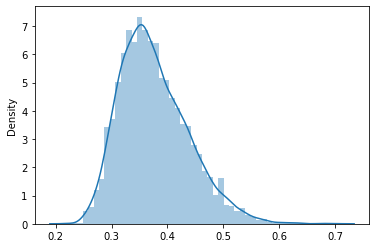

In [26]:
sns.distplot(train_copy['age']/train_copy['stat_overall'])
plt.show()

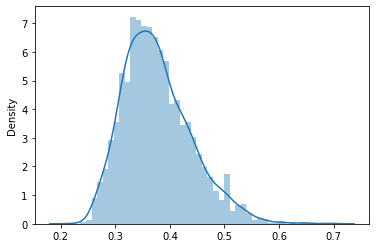

In [27]:
sns.distplot(test_copy['age']/test_copy['stat_overall'])
plt.show()

In [28]:
train_copy

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,age_overall,age_potential,contract
0,31,south america,2021,ST,left,5.0,94,94,4.0,0.329787,0.329787,3
1,27,europe,2020,GK,right,4.0,91,93,1.0,0.296703,0.290323,2
2,31,south america,2021,ST,right,5.0,91,91,3.0,0.340659,0.340659,3
3,32,europe,2020,DF,right,4.0,91,91,3.0,0.351648,0.351648,2
4,25,europe,2021,GK,right,3.0,90,93,1.0,0.277778,0.268817,3
...,...,...,...,...,...,...,...,...,...,...,...,...
8927,18,africa,2019,MF,right,1.0,48,63,3.0,0.375000,0.285714,1
8928,19,europe,2020,DF,right,1.0,47,59,2.0,0.404255,0.322034,2
8929,18,south america,2021,DF,right,1.0,47,64,2.0,0.382979,0.281250,3
8930,18,europe,2021,GK,right,1.0,47,65,1.0,0.382979,0.276923,3


---

# 모델링

In [29]:
object_le = LabelEncoder()
train_copy[['continent','position','prefer_foot']] = train_copy[['continent','position','prefer_foot']].apply(object_le.fit_transform)

train_copy = pd.get_dummies(data= train_copy, columns=['continent'], prefix=['continent'])
train_copy = pd.get_dummies(data= train_copy, columns=['position'], prefix=['position'])
train_copy = pd.get_dummies(data= train_copy, columns=['prefer_foot'], prefix=['prefer_foot'])

test_copy[['continent','position','prefer_foot']] = test_copy[['continent','position','prefer_foot']].apply(object_le.fit_transform)
test_copy = pd.get_dummies(data= test_copy, columns=['continent'], prefix=['continent'])
test_copy = pd.get_dummies(data= test_copy, columns=['position'], prefix=['position'])
test_copy = pd.get_dummies(data= test_copy, columns=['prefer_foot'], prefix=['prefer_foot'])

In [30]:
scaler = RobustScaler()
train_copy[['age','stat_overall','stat_potential']] = scaler.fit_transform(train_copy[['age','stat_overall','stat_potential']])
test_copy[['age','stat_overall','stat_potential']] = scaler.transform(test_copy[['age','stat_overall','stat_potential']])

# 스태킹 안하고 회귀모델 평균으로

In [31]:
X_train, X_valid, y_train, y_valid=train_test_split(train_copy, target, test_size=0.2, random_state=0)

In [32]:
def RMSE(true, pred):
    mse = mean_squared_error(true, pred)
    score = np.sqrt(mse)
    return score

nmae_score = make_scorer(RMSE, greater_is_better=False)

* 최적 하이퍼 파라미터 찾기

In [56]:
cat_reg = CatBoostRegressor(random_state=42)
param_grid = {'learning_rate':[0.01,0.03,0.05,0.1,0.2,0.3],
              'depth':[2,3,4,5,6,7,8,9,10],
              'verbose':[0]}

grid_cv = GridSearchCV(cat_reg,param_grid = param_grid,cv=10,n_jobs=-1)
grid_cv.fit(X_train,y_train)

print(grid_cv.best_params_)

{'depth': 6, 'learning_rate': 0.1, 'verbose': 0}


* 모델 생성

In [12]:
etr = ExtraTreesRegressor(max_depth=10,n_estimators=200)
lr = LinearRegression()
rg = Ridge()
rf = RandomForestRegressor(random_state=42,max_depth=12,n_estimators=100)
gbr = GradientBoostingRegressor(random_state=42,learning_rate=0.1,max_depth=5,n_estimators=150)
xgb = XGBRegressor(random_state=42,learning_rate=0.1, max_depth=8, n_estimators=150)
lgb = LGBMRegressor(random_state=42,learning_rate=0.1,max_depth=12,n_estimators=150)
ada = AdaBoostRegressor(random_state=42,learning_rate=0.1,n_estimators=200)
hgb = HistGradientBoostingRegressor(random_state=42,learning_rate=0.1)
ngb = NGBRegressor(random_state=42,verbose=0,n_estimators=600,learning_rate=0.1)
cat = CatBoostRegressor(random_state=42,verbose=0,depth=5,learning_rate=0.1)

* 모델 학습

In [13]:
etr.fit(X_train,y_train)
lr.fit(X_train,y_train)
rg.fit(X_train,y_train)
rf.fit(X_train,y_train)
gbr.fit(X_train,y_train)
xgb.fit(X_train,y_train)
lgb.fit(X_train,y_train)
ada.fit(X_train,y_train)
hgb.fit(X_train,y_train)
ngb.fit(X_train,y_train)
cat.fit(X_train,y_train)

* test value 예측

In [14]:
y_etr = etr.predict(X_valid)
y_lr = lr.predict(X_valid)
y_rg = rg.predict(X_valid)
y_rf = rf.predict(X_valid)
y_gbr = gbr.predict(X_valid)
y_xgb = xgb.predict(X_valid)
y_lgb = lgb.predict(X_valid)
y_ada = ada.predict(X_valid)
y_hgb = hgb.predict(X_valid)
y_ngb = ngb.predict(X_valid)
y_cat = cat.predict(X_valid)

* score 확인

In [15]:
score_etr = RMSE(y_valid,y_etr)
score_lr = RMSE(y_valid,y_lr)
score_rg = RMSE(y_valid,y_rg)
score_rf = RMSE(y_valid,y_rf)
score_gbr = RMSE(y_valid,y_gbr)
score_xgb = RMSE(y_valid,y_xgb)
score_lgb = RMSE(y_valid,y_lgb)
score_ada = RMSE(y_valid,y_ada)
score_hgb = RMSE(y_valid,y_hgb)
score_ngb = RMSE(y_valid,y_ngb)
score_cat = RMSE(y_valid,y_cat)

* score 출력

In [16]:
print('etr',score_etr)
print('lr ',score_lr)
print('rg ',score_rg)
print('rf ',score_rf)
print('gbr',score_gbr)
print('xgb',score_xgb)
print('lgb',score_lgb)
print('ada',score_ada)
print('hgb',score_hgb)
print('ngb',score_ngb)
print('cat',score_cat)

etr 0.08361738846223668
lr  0.22138300389542512
rg  0.2297266686016237
rf  0.08707404589555233
gbr 0.0755017218851355
xgb 0.07539455724392584
lgb 0.07593506713235679
ada 0.29452397229644234
hgb 0.0801086627221265
ngb 0.07399326380056215
cat 0.0665994920827646


#### 좋은 성능을 보인 모델은 ETR,RF,GBR,XGB,LGB,HGB,NGB,CAT 모델이 있습니다

### KFOLD로 fold별 val값, predict값을 평균내서 일반화 성능을 끌어 올립니다.

In [17]:
kf = KFold(n_splits=10,random_state=42,shuffle=True)

In [24]:
# ExtraTreesRegression
etr_pred = np.zeros(test_copy.shape[0])
etr_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_copy, target)) :
    tr_x, tr_y = train_copy.iloc[tr_idx], target.iloc[tr_idx]
    val_x, val_y = train_copy.iloc[val_idx], np.expm1(target.iloc[val_idx])
    
    etr = ExtraTreesRegressor(random_state=42,max_depth=10,n_estimators=200)
    etr.fit(tr_x, tr_y)
    
    val_pred = np.expm1(etr.predict(val_x))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    etr_val.append(val_rmse)
    print(f'{n + 1} FOLD RMSE = {val_rmse}')
    
    target_data = Pool(data = test_copy, label = None)
    fold_pred = etr.predict(test_copy) / 10
    etr_pred += fold_pred
print(f'10FOLD Mean of RMSE = {np.mean(etr_val)}')

1 FOLD RMSE = 948891.6803233995
2 FOLD RMSE = 1439553.3263649822
3 FOLD RMSE = 550705.679636224
4 FOLD RMSE = 716380.1929792577
5 FOLD RMSE = 685308.6590309615
6 FOLD RMSE = 676201.8197984353
7 FOLD RMSE = 693335.442502087
8 FOLD RMSE = 800627.4300574928
9 FOLD RMSE = 854254.003762837
10 FOLD RMSE = 517514.40833157056
10FOLD Mean of RMSE = 788277.2642787247


In [27]:
# RandomForestRegressor
rf_pred = np.zeros(test_copy.shape[0])
rf_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_copy, target)) :
    tr_x, tr_y = train_copy.iloc[tr_idx], target.iloc[tr_idx]
    val_x, val_y = train_copy.iloc[val_idx], np.expm1(target.iloc[val_idx])
    
    rf = RandomForestRegressor(random_state=42,max_depth=12,n_estimators=100)
    rf.fit(tr_x, tr_y)
    
    val_pred = np.expm1(rf.predict(val_x))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    rf_val.append(val_rmse)
    print(f'{n + 1} FOLD RMSE = {val_rmse}')
    
    fold_pred = rf.predict(test_copy) / 10
    rf_pred += fold_pred
print(f'10FOLD Mean of RMSE = {np.mean(rf_val)}')

1 FOLD RMSE = 913352.5576400522
2 FOLD RMSE = 1452880.736807408
3 FOLD RMSE = 460032.7148063862
4 FOLD RMSE = 422496.1814684256
5 FOLD RMSE = 685793.5583447923
6 FOLD RMSE = 616683.3176070952
7 FOLD RMSE = 719791.7150238164
8 FOLD RMSE = 781173.8212326324
9 FOLD RMSE = 941447.5961878216
10 FOLD RMSE = 511078.58351355215
10FOLD Mean of RMSE = 750473.0782631983


In [28]:
# GradientBoostingRegressor
gbr_pred = np.zeros(test_copy.shape[0])
gbr_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_copy, target)) :
    tr_x, tr_y = train_copy.iloc[tr_idx], target.iloc[tr_idx]
    val_x, val_y = train_copy.iloc[val_idx], np.expm1(target.iloc[val_idx])
    
    gbr = GradientBoostingRegressor(random_state=42,learning_rate=0.1,max_depth=5,n_estimators=150)
    gbr.fit(tr_x, tr_y)
    
    val_pred = np.expm1(gbr.predict(val_x))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    gbr_val.append(val_rmse)
    print(f'{n + 1} FOLD RMSE = {val_rmse}')

    fold_pred = gbr.predict(test_copy) / 10
    gbr_pred += fold_pred
print(f'10FOLD Mean of RMSE = {np.mean(gbr_val)}')

1 FOLD RMSE = 427906.8327974129
2 FOLD RMSE = 1052260.9255155055
3 FOLD RMSE = 437724.2606193203
4 FOLD RMSE = 381496.924803332
5 FOLD RMSE = 484297.4854728498
6 FOLD RMSE = 446629.3017581576
7 FOLD RMSE = 413156.90019545285
8 FOLD RMSE = 630945.0753017688
9 FOLD RMSE = 636058.1159282451
10 FOLD RMSE = 592441.6211967897
10FOLD Mean of RMSE = 550291.7443588835


In [29]:
# XGBRegressor
xgb_pred = np.zeros(test_copy.shape[0])
xgb_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_copy, target)) :
    tr_x, tr_y = train_copy.iloc[tr_idx], target.iloc[tr_idx]
    val_x, val_y = train_copy.iloc[val_idx], np.expm1(target.iloc[val_idx])
    
    xgb = XGBRegressor(random_state=42,learning_rate=0.1, max_depth=8, n_estimators=150)
    xgb.fit(tr_x, tr_y)
    
    val_pred = np.expm1(xgb.predict(val_x))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    xgb_val.append(val_rmse)
    print(f'{n + 1} FOLD RMSE = {val_rmse}')

    fold_pred = xgb.predict(test_copy) / 10
    xgb_pred += fold_pred
print(f'10FOLD Mean of RMSE = {np.mean(xgb_val)}')

1 FOLD RMSE = 516409.6285444195
2 FOLD RMSE = 1182418.1151070104
3 FOLD RMSE = 416329.04326413834
4 FOLD RMSE = 276495.9000091559
5 FOLD RMSE = 492698.1787845808
6 FOLD RMSE = 417926.75479741814
7 FOLD RMSE = 591497.5935391117
8 FOLD RMSE = 495121.1056282029
9 FOLD RMSE = 586505.8711638438
10 FOLD RMSE = 510484.8726266649
10FOLD Mean of RMSE = 548588.7063464547


In [30]:
# LGBMRegressor
lgb_pred = np.zeros(test_copy.shape[0])
lgb_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_copy, target)) :
    tr_x, tr_y = train_copy.iloc[tr_idx], target.iloc[tr_idx]
    val_x, val_y = train_copy.iloc[val_idx], np.expm1(target.iloc[val_idx])
    
    lgb = LGBMRegressor(random_state=42,learning_rate=0.1,max_depth=12,n_estimators=150)
    lgb.fit(tr_x, tr_y)
    
    val_pred = np.expm1(lgb.predict(val_x))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    lgb_val.append(val_rmse)
    print(f'{n + 1} FOLD RMSE = {val_rmse}')

    fold_pred = lgb.predict(test_copy) / 10
    lgb_pred += fold_pred
print(f'10FOLD Mean of RMSE = {np.mean(lgb_val)}')

1 FOLD RMSE = 484119.08651433355
2 FOLD RMSE = 1450775.3518380974
3 FOLD RMSE = 424158.35299429524
4 FOLD RMSE = 345203.410558015
5 FOLD RMSE = 466942.99992754345
6 FOLD RMSE = 439570.4840154903
7 FOLD RMSE = 285517.8055940142
8 FOLD RMSE = 758288.2631487295
9 FOLD RMSE = 530424.6556446473
10 FOLD RMSE = 650696.7764120777
10FOLD Mean of RMSE = 583569.7186647244


In [31]:
# HGBRegressor
hgb_pred = np.zeros(test_copy.shape[0])
hgb_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_copy, target)) :
    tr_x, tr_y = train_copy.iloc[tr_idx], target.iloc[tr_idx]
    val_x, val_y = train_copy.iloc[val_idx], np.expm1(target.iloc[val_idx])
    
    hgb = HistGradientBoostingRegressor(random_state=42,learning_rate=0.1)
    hgb.fit(tr_x, tr_y)
    
    val_pred = np.expm1(hgb.predict(val_x))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    hgb_val.append(val_rmse)
    print(f'{n + 1} FOLD RMSE = {val_rmse}')

    fold_pred = hgb.predict(test_copy) / 10
    hgb_pred += fold_pred
print(f'10FOLD Mean of RMSE = {np.mean(hgb_val)}')

1 FOLD RMSE = 521448.94880845386
2 FOLD RMSE = 1546286.980044712
3 FOLD RMSE = 420196.2313745927
4 FOLD RMSE = 403352.33656942175
5 FOLD RMSE = 402575.8190251027
6 FOLD RMSE = 442643.79489537474
7 FOLD RMSE = 284757.6142374566
8 FOLD RMSE = 711296.9288947331
9 FOLD RMSE = 603200.4366449522
10 FOLD RMSE = 572356.2741069396
10FOLD Mean of RMSE = 590811.5364601739


In [32]:
# NGBRegressor
ngb_pred = np.zeros(test_copy.shape[0])
ngb_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_copy, target)) :
    tr_x, tr_y = train_copy.iloc[tr_idx], target.iloc[tr_idx]
    val_x, val_y = train_copy.iloc[val_idx], np.expm1(target.iloc[val_idx])
    
    ngb = NGBRegressor(random_state=42,verbose=0,n_estimators=600,learning_rate=0.1)
    ngb.fit(tr_x, tr_y)
    
    val_pred = np.expm1(ngb.predict(val_x))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    ngb_val.append(val_rmse)
    print(f'{n + 1} FOLD RMSE = {val_rmse}')

    fold_pred = ngb.predict(test_copy) / 10
    ngb_pred += fold_pred
print(f'10FOLD Mean of RMSE = {np.mean(ngb_val)}')

1 FOLD RMSE = 585659.0897915956
2 FOLD RMSE = 524209.96740416466
3 FOLD RMSE = 404829.40147517517
4 FOLD RMSE = 399969.8628614627
5 FOLD RMSE = 414891.91612469405
6 FOLD RMSE = 345503.2062614265
7 FOLD RMSE = 353168.7563634851
8 FOLD RMSE = 399356.7809365679
9 FOLD RMSE = 561121.161849911
10 FOLD RMSE = 531232.9164383676
10FOLD Mean of RMSE = 451994.30595068505


In [63]:
# CatBoostRegressor
cat_pred = np.zeros(test_copy.shape[0])
cat_val = []
for n, (tr_idx, val_idx) in enumerate(kf.split(train_copy, target)) :
    tr_x, tr_y = train_copy.iloc[tr_idx], target.iloc[tr_idx]
    val_x, val_y = train_copy.iloc[val_idx], np.expm1(target.iloc[val_idx])
    
    tr_data = Pool(data = tr_x, label = tr_y)
    val_data = Pool(data = val_x, label = val_y)
    
    # cat = CatBoostRegressor(random_state=42,verbose=0,depth=5,learning_rate=0.1) #최고 점수 하이퍼파라미터
    # cat = CatBoostRegressor(random_state=42,verbose=0,depth=6,learning_rate=0.1)
    cat = CatBoostRegressor(random_state=42,verbose=0,depth=6,n_estimators=500,learning_rate=0.1)
    cat.fit(tr_data, eval_set = val_data, early_stopping_rounds = 750, verbose = 1000)
    
    val_pred = np.expm1(cat.predict(val_x))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    cat_val.append(val_rmse)
    print(f'{n + 1} FOLD RMSE = {val_rmse}')
    
    target_data = Pool(data = test_copy, label = None)
    fold_pred = cat.predict(test_copy) / 10
    cat_pred += fold_pred
print(f'10FOLD Mean of NMAE = {np.mean(cat_val)}')

0:	learn: 1.2766564	test: 7384656.5935179	best: 7384656.5935179 (0)	total: 1.74ms	remaining: 869ms
499:	learn: 0.0514141	test: 7384655.7753763	best: 7384655.7753763 (499)	total: 790ms	remaining: 0us

bestTest = 7384655.775
bestIteration = 499

1 FOLD RMSE = 429337.3282684079
0:	learn: 1.2790082	test: 7319276.2833160	best: 7319276.2833160 (0)	total: 1.96ms	remaining: 980ms
499:	learn: 0.0512558	test: 7319275.4660577	best: 7319275.4660430 (497)	total: 774ms	remaining: 0us

bestTest = 7319275.466
bestIteration = 497

Shrink model to first 498 iterations.
2 FOLD RMSE = 1028504.2878411263
0:	learn: 1.2870015	test: 5698484.4504983	best: 5698484.4504983 (0)	total: 2.04ms	remaining: 1.02s
499:	learn: 0.0507355	test: 5698483.6296615	best: 5698483.6296360 (488)	total: 773ms	remaining: 0us

bestTest = 5698483.63
bestIteration = 488

Shrink model to first 489 iterations.
3 FOLD RMSE = 392132.40549606376
0:	learn: 1.2861489	test: 5952005.0454509	best: 5952005.0454509 (0)	total: 1.77ms	remaining: 88

* 검증 성능 확인하기

In [47]:
val_list = [etr_val, rf_val, gbr_val, xgb_val, lgb_val, hgb_val, ngb_val, cat_val]
for val in val_list:
    print("{:.8f}".format(np.mean(val)))

788277.26427872
750473.07826320
550291.74435888
548588.70634645
583569.71866472
590811.53646017
451994.30595069
476878.55851660


### 성능이 좋은 GBR, XGB, NGB, CAT 산술평균

In [43]:
submission['value'] = (np.expm1(gbr_pred) + np.expm1(xgb_pred) + np.expm1(ngb_pred) + np.expm1(cat_pred)) / 4
submission
# submission.to_csv('gbr xgb ngb cat rmse hyper.csv',index=False)

,id,value
0,1,7.625804e+07
1,2,9.555855e+07
2,4,8.019696e+07
3,5,8.339690e+07
4,6,6.432155e+07
...,...,...
3823,16924,5.743668e+04
3824,16929,4.550794e+04
3825,16932,5.487842e+04
3826,16937,4.739486e+04


# 성능이 가장 좋은 catboost만 이용

In [64]:
submission['value'] = np.expm1(cat_pred)
submission
# submission.to_csv('cat rmse hyper depth6.csv',index=False)

,id,value
0,1,5.922038e+07
1,2,9.716955e+07
2,4,8.190169e+07
3,5,8.532303e+07
4,6,6.349409e+07
...,...,...
3823,16924,5.857539e+04
3824,16929,4.667115e+04
3825,16932,5.725702e+04
3826,16937,5.304603e+04


---

# learning curve

Mean training scores

 1       2.065271e-11
100     5.943243e-06
500     1.076223e-04
2000    1.140072e-03
5000    1.721186e-03
7145    1.910344e-03
dtype: float64

 --------------------

Mean validation scores

 1       23.043815
100     11.836826
500      6.909645
2000     2.690348
5000     0.601019
7145     0.312729
dtype: float64


(0.0, 24.0)

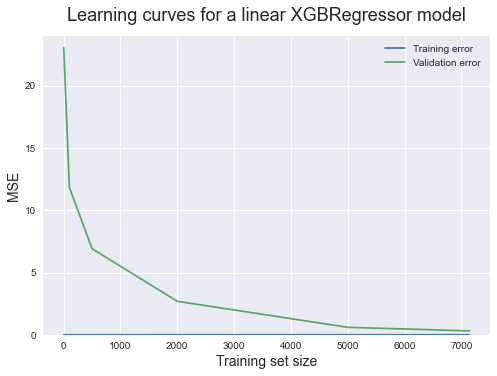

In [19]:
train_sizes = [1,100, 500, 2000, 5000, 7145]

train_sizes, train_scores, validation_scores = learning_curve(
estimator = xgb.XGBRegressor(),
X = train_copy[train_copy.columns],
y = target, train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

# print('Training scores:\n\n', train_scores)
# print('\n', '-' * 70) # separator to make the output easy to read
# print('\nValidation scores:\n\n', validation_scores)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear XGBRegressor model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,24)

---
하이퍼 파라미터

Mean training scores

 1       301.344878
100       0.000306
500       0.001326
2000      0.002553
5000      0.003213
7145      0.003485
dtype: float64

 --------------------

Mean validation scores

 1       178.684252
100      11.777511
500       6.790158
2000      2.601594
5000      0.564901
7145      0.286191
dtype: float64


(0.0, 12.0)

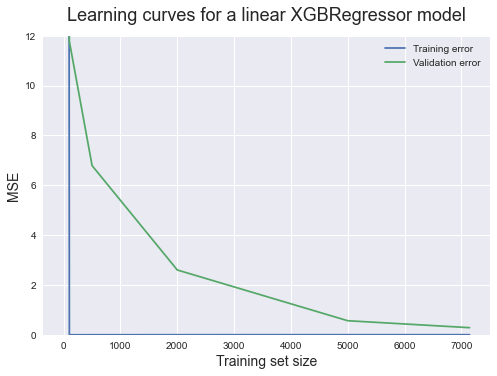

In [20]:
train_sizes = [1,100, 500, 2000, 5000, 7145]

train_sizes, train_scores, validation_scores = learning_curve(
estimator = xgb.XGBRegressor(learning_rate = 0.1,
                             n_estimators=1000,
                             max_depth=3,
                             min_child_weight=5,
                             gamma=0,
                             # reg_alpah=1e-05,
                             subsample=0.71,
                             colsample_bytree=0.6,
                             # objective='reg:linear',
                             nthread=-1,
                             scale_pos_weight=1,
                             seed=42),
X = train_copy[train_copy.columns],
y = target, train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

# print('Training scores:\n\n', train_scores)
# print('\n', '-' * 70) # separator to make the output easy to read
# print('\nValidation scores:\n\n', validation_scores)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear XGBRegressor model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,12)